In [34]:
import os
import glob
import math
from typing import List, Tuple, Optional, Dict

import numpy as np
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split

In [35]:
# Check GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

if device.type == 'cuda':
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"VRAM: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

Using device: cuda
GPU: NVIDIA H100 NVL
VRAM: 99.9 GB


In [ ]:
WAVELENGTHS_NM = list(range(400, 701, 10))  # 31 bands 400-700nm[10][13]

def load_16bit_png(path: str) -> np.ndarray:
    # returns float32 in [0,1]
    with Image.open(path) as im:
        arr = np.array(im, dtype=np.uint16)
    arr = arr.astype(np.float32)
    maxv = 65535.0 if arr.max() > 255 else 255.0
    return np.clip(arr / maxv, 0.0, 1.0)

def simple_rgb_from_hsi(hsi: np.ndarray) -> np.ndarray:
    # hsi shape (H,W,B). Pick bands nearest to ~460(B), ~540(G), ~620(R)
    bands = { 'B': 460, 'G': 540, 'R': 620 }
    idx = {k: int(round((wl - 400)/10)) for k, wl in bands.items()}
    r = hsi[..., idx['R']]
    g = hsi[..., idx['G']]
    b = hsi[..., idx['B']]
    rgb = np.stack([r, g, b], axis=-1)
    rgb = np.clip(rgb, 0.0, 1.0)
    return rgb.astype(np.float32)

class CAVEBandsFolder(Dataset):
    def __init__(self, root_dir: str, scenes: Optional[List[str]] = None, patch_size: Optional[int] = None):
        self.root_dir = root_dir
        if scenes is None:
            candidates = []
            for d in sorted(os.listdir(root_dir)):
                p = os.path.join(root_dir, d)
                if os.path.isdir(p):
                    candidates.append(d)
        else:
            candidates = scenes

        self.scenes = []
        self.scene_band_paths = []

        for s in candidates:
            folder = os.path.join(root_dir, s, s)
            files = sorted(glob.glob(os.path.join(folder, f"{os.path.basename(s)}_*.png")))
            files = [p for p in files if p[-6:-4].isdigit()]
            files = sorted(files, key=lambda p: int(p[-6:-4]))

            if len(files) == 31:
                self.scenes.append(s)
                self.scene_band_paths.append(files)

        if len(self.scene_band_paths) == 0:
            raise RuntimeError(f"No valid CAVE scenes found under {root_dir}. Check folder nesting and filenames.")
        self.patch_size = patch_size


    def __len__(self):
        return len(self.scene_band_paths)

    def __getitem__(self, idx):
        band_files = self.scene_band_paths[idx]
        bands = []
        for i, p in enumerate(band_files):
            band = load_16bit_png(p)
            bands.append(band)

        hsi = np.stack(bands, axis=-1).astype(np.float32)  # (H,W,31)
        if hsi.ndim != 3 or hsi.shape[2] != 31:
            raise ValueError(f"HSI should be (H,W,31), got {hsi.shape}, file={band_files}")
        H, W, C = hsi.shape  

        # Try to load camera RGB if present
        scene_dir = os.path.dirname(os.path.dirname(band_files[0]))
        rgb_img = None
        for ext in ("bmp", "png", "jpg", "jpeg"):
            rgb_path = os.path.join(scene_dir, f"{os.path.basename(scene_dir)}_RGB.{ext}")
            if os.path.exists(rgb_path):
                rgb_img = load_16bit_png(rgb_path)
                if rgb_img.ndim == 2:
                    rgb_img = np.stack([rgb_img]*3, axis=-1)
                break
        if rgb_img is not None and rgb_img.shape[2] == 3:
            rgb = np.clip(rgb_img, 0.0, 1.0)
        else:
            rgb = simple_rgb_from_hsi(hsi)
        if rgb.shape != (H, W, 3):
            raise ValueError(f"RGB bad shape: {rgb.shape} expected ({H},{W},3)")

        # (optional)
        if self.patch_size is not None:
            ps = self.patch_size
            if H >= ps and W >= ps:
                y = np.random.randint(0, H-ps+1)
                x = np.random.randint(0, W-ps+1)
                hsi = hsi[y:y+ps, x:x+ps, :]
                rgb = rgb[y:y+ps, x:x+ps, :]

        # to torch tensors (C, H, W)
        hsi_t = torch.from_numpy(hsi).permute(2,0,1).contiguous()  # (31,H,W)
        rgb_t = torch.from_numpy(rgb).permute(2,0,1).contiguous()  # (3, H,W)
        return {'rgb': rgb_t, 'hsi': hsi_t}


torch.Size([3, 512, 512]) torch.Size([31, 512, 512])


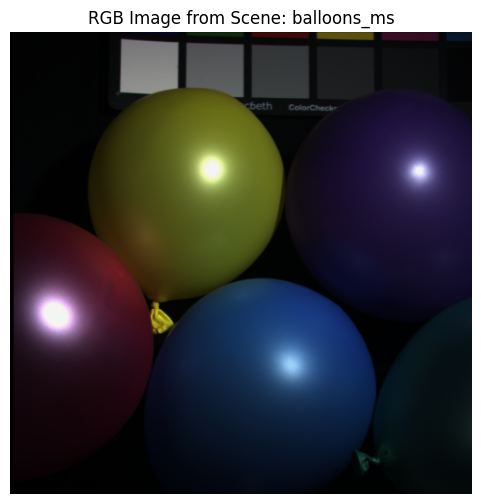

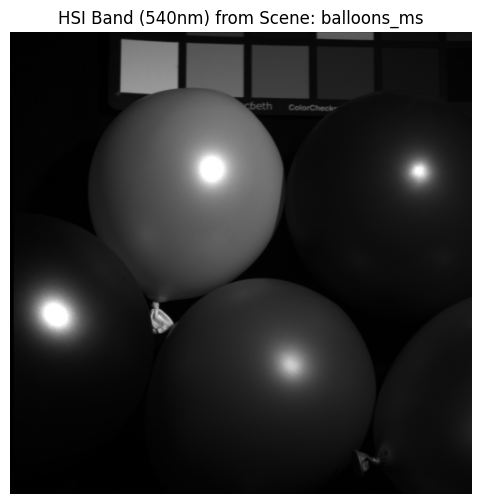

In [ ]:
cave_root = "./cave_dataset"
scenes = ["balloons_ms"] 
ds = CAVEBandsFolder(cave_root, scenes=scenes, patch_size=None)
sample = ds[0]
print(sample['rgb'].shape, sample['hsi'].shape)

import matplotlib.pyplot as plt

# Display the RGB image
plt.figure(figsize=(6, 6))
plt.imshow(sample['rgb'].permute(1, 2, 0).numpy())
plt.title(f"RGB Image from Scene: {ds.scenes[0]}")
plt.axis('off')
plt.show()

# Display one of the HSI bands (e.g., the middle band)
plt.figure(figsize=(6, 6))
plt.imshow(sample['hsi'][15].numpy(), cmap='gray') # Displaying the 16th band (index 15)
plt.title(f"HSI Band (540nm) from Scene: {ds.scenes[0]}")
plt.axis('off')
plt.show()

# PART-1 

In [38]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import math

class SpectralMultiHeadSelfAttention(nn.Module):
    def __init__(self, dim, num_heads=1):
        super().__init__()
        assert dim % num_heads == 0
        self.dim = dim
        self.num_heads = num_heads
        self.head_dim = dim // num_heads
        self.qkv = nn.Linear(dim, dim * 3, bias=False)
        self.proj = nn.Linear(dim, dim)
        self.scale_params = nn.Parameter(torch.ones(num_heads))

    def forward(self, x):  # x: (B, H, W, C)
        B, H, W, C = x.shape
        HW = H * W
        qkv = self.qkv(x.reshape(B, HW, C))                    # (B, HW, 3C)
        q, k, v = qkv.chunk(3, dim=-1)                      # (B, HW, C) each
        # split heads along C
        q = q.reshape(B, HW, self.num_heads, self.head_dim).permute(0, 2, 1, 3)  # (B, heads, HW, dh)
        k = k.reshape(B, HW, self.num_heads, self.head_dim).permute(0, 2, 1, 3)  # (B, heads, HW, dh)
        v = v.reshape(B, HW, self.num_heads, self.head_dim).permute(0, 2, 1, 3)  # (B, heads, HW, dh)
        # A_j = softmax( σ_j * K_j^T Q_j ) across HW as inner dim -> (B, heads, dh, dh)
        scores = torch.matmul(k.transpose(-2, -1), q)                           # (B, heads, dh, dh)
        scores = scores * self.scale_params.view(1, self.num_heads, 1, 1)       # per-head σ_j
        attn = scores.softmax(dim=-1)                                           # (B, heads, dh, dh)
        # head_j = V_j A_j : (B, heads, HW, dh)
        out = torch.matmul(v, attn)                                             # (B, heads, HW, dh)
        out = out.permute(0, 2, 1, 3).reshape(B, HW, C)                         # (B, HW, C)
        out = self.proj(out).reshape(B, H, W, C)                                   # (B, H, W, C)
        return out

    
class PositionEmbedding(nn.Module):
    """Position embedding for spectral channels using depth-wise convolutions"""
    def __init__(self, dim):
        super().__init__()
        self.proj = nn.Sequential(
            nn.Conv2d(dim, dim, 3, 1, 1, groups=dim),  # Depth-wise conv
            nn.GELU(),
            nn.Conv2d(dim, dim, 3, 1, 1, groups=dim),  # Depth-wise conv
        )
    
    def forward(self, x):
        # x: (B, H, W, C) -> (B, C, H, W)
        x = x.permute(0, 3, 1, 2)
        x = self.proj(x)
        # Back to (B, H, W, C)
        x = x.permute(0, 2, 3, 1)
        return x
    
class FeedForward(nn.Module):
    """Feed Forward Network (FFN) with depth-wise convolution"""
    def __init__(self, dim, hidden_dim=None):
        super().__init__()
        hidden_dim = hidden_dim or dim * 4
        
        self.net = nn.Sequential(
            nn.Conv2d(dim, hidden_dim, 1),  # 1x1 conv
            nn.GELU(),
            nn.Conv2d(hidden_dim, hidden_dim, 3, 1, 1, groups=hidden_dim),  # DW conv 3x3
            nn.GELU(),
            nn.Conv2d(hidden_dim, dim, 1),  # 1x1 conv
        )
    
    def forward(self, x):
        # x: (B, H, W, C) -> (B, C, H, W)
        x = x.permute(0, 3, 1, 2)
        x = self.net(x)
        # Back to (B, H, W, C)
        x = x.permute(0, 2, 3, 1)
        return x
    
class SpectralAttentionBlock(nn.Module):
    def __init__(self, dim, num_heads=1, ffn_hidden_dim=None):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim, eps=1e-6)
        self.attn = SpectralMultiHeadSelfAttention(dim, num_heads)
        self.pos_embed = PositionEmbedding(dim)
        self.norm2 = nn.LayerNorm(dim, eps=1e-6)
        self.ffn = FeedForward(dim, ffn_hidden_dim)

    def forward(self, x):                 # x: (B, C, H, W)
        B, C, H, W = x.shape
        x_bhwc = x.permute(0, 2, 3, 1)   # (B, H, W, C)
        y = self.attn(self.norm1(x_bhwc)) + self.pos_embed(self.norm1(x_bhwc))  # (B, H, W, C)
        x_bhwc = x_bhwc + y
        x_bhwc = x_bhwc + self.ffn(self.norm2(x_bhwc))
        return x_bhwc.permute(0, 3, 1, 2)  # (B, C, H, W)

    
# Test the components
if __name__ == "__main__":
    # Test with sample input
    B, C, H, W = 2, 31, 64, 64  # Batch size, channels, height, width
    x = torch.randn(B, C, H, W)
    
    print("Testing core components...")
    print(f"Input shape: {x.shape}")
    
    # Test SAB
    sab = SpectralAttentionBlock(dim=31, num_heads=1)
    out = sab(x)
    print(f"SAB output shape: {out.shape}")
    
    print("Part 1 completed successfully!")

Testing core components...
Input shape: torch.Size([2, 31, 64, 64])
SAB output shape: torch.Size([2, 31, 64, 64])
Part 1 completed successfully!


# Part 2

In [39]:
class DownSample(nn.Module):
    """Downsampling using strided conv4x4"""
    def __init__(self, in_channels, scale_factor=2):
        super().__init__()
        self.scale_factor = scale_factor
        self.conv = nn.Conv2d(in_channels, in_channels, 
                             kernel_size=4, stride=scale_factor, padding=1)
    
    def forward(self, x):
        return self.conv(x)
class UpSample(nn.Module):
    """Upsampling using strided deconv2x2"""
    def __init__(self, in_channels, scale_factor=2):
        super().__init__()
        self.scale_factor = scale_factor
        self.conv = nn.ConvTranspose2d(in_channels, in_channels, 
                                      kernel_size=2, stride=scale_factor)
    
    def forward(self, x):
        return self.conv(x)
class SkipConnection(nn.Module):
    """Skip connection with 1x1 conv for channel alignment"""
    def __init__(self, channels):
        super().__init__()
        self.conv = nn.Conv2d(channels, channels, 1)
    
    def forward(self, x):
        return self.conv(x)
class SingleStageSpectralTransformer(nn.Module):
    """
    Single-stage Spectral-wise Transformer (SST)
    U-shaped architecture with encoder, bottleneck, and decoder
    """
    def __init__(self, dim, num_blocks=[1, 1, 1], num_heads=1):
        super().__init__()
        self.dim = dim
        self.num_blocks = num_blocks  # [N1, N2, N3] for encoder1, encoder2, bottleneck
        
        # Embedding layer (conv3x3)
        self.embedding = nn.Conv2d(dim, dim, 3, 1, 1)
        
        # Encoder Stage 1
        self.encoder1_blocks = nn.ModuleList([
            SpectralAttentionBlock(dim, num_heads) for _ in range(num_blocks[0])
        ])
        self.downsample1 = DownSample(dim, scale_factor=2)
        
        # Encoder Stage 2  
        self.encoder2_blocks = nn.ModuleList([
            SpectralAttentionBlock(dim, num_heads) for _ in range(num_blocks[1])
        ])
        self.downsample2 = DownSample(dim, scale_factor=2)
        
        # Bottleneck
        self.bottleneck_blocks = nn.ModuleList([
            SpectralAttentionBlock(dim, num_heads) for _ in range(num_blocks[2])
        ])
        
        # Decoder Stage 1
        self.upsample1 = UpSample(dim, scale_factor=2)
        self.decoder1_blocks = nn.ModuleList([
            SpectralAttentionBlock(dim, num_heads) for _ in range(num_blocks[1])
        ])
        self.skip_conv1 = SkipConnection(dim)
        
        # Decoder Stage 2
        self.upsample2 = UpSample(dim, scale_factor=2)  
        self.decoder2_blocks = nn.ModuleList([
            SpectralAttentionBlock(dim, num_heads) for _ in range(num_blocks[0])
        ])
        self.skip_conv2 = SkipConnection(dim)
        
        # Mapping layer (conv3x3)
        self.mapping = nn.Conv2d(dim, dim, 3, 1, 1)
        
    def forward(self, x):
        # Input: (B, C, H, W)
        identity = x
        
        # Embedding
        x = self.embedding(x)
        
        # Encoder Stage 1
        x1 = x
        for block in self.encoder1_blocks:
            x1 = block(x1)
        skip1 = x1  # Save for skip connection
        x1 = self.downsample1(x1)  # H/2, W/2
        
        # Encoder Stage 2
        x2 = x1
        for block in self.encoder2_blocks:
            x2 = block(x2)
        skip2 = x2  # Save for skip connection
        x2 = self.downsample2(x2)  # H/4, W/4
        
        # Bottleneck
        x_bottle = x2
        for block in self.bottleneck_blocks:
            x_bottle = block(x_bottle)
        
        # Decoder Stage 1
        x_up1 = self.upsample1(x_bottle)  # Back to H/2, W/2
        skip2_processed = self.skip_conv1(skip2)
        x_up1 = x_up1 + skip2_processed  # Skip connection
        for block in self.decoder1_blocks:
            x_up1 = block(x_up1)
            
        # Decoder Stage 2
        x_up2 = self.upsample2(x_up1)  # Back to H, W
        skip1_processed = self.skip_conv2(skip1)
        x_up2 = x_up2 + skip1_processed  # Skip connection
        for block in self.decoder2_blocks:
            x_up2 = block(x_up2)
        
        # Mapping
        out = self.mapping(x_up2)
        
        # Long identity mapping
        out = out + identity
        
        return out
# Test the SST
if __name__ == "__main__":
    # Test with sample input
    B, C, H, W = 2, 31, 128, 128  # Batch size, channels, height, width
    x = torch.randn(B, C, H, W)
    
    print("Testing Single-stage Spectral-wise Transformer (SST)...")
    print(f"Input shape: {x.shape}")
    
    # Test SST with default configuration (N1=N2=N3=1)
    sst = SingleStageSpectralTransformer(dim=31, num_blocks=[1, 1, 1], num_heads=1)
    
    # Forward pass
    out = sst(x)
    print(f"SST output shape: {out.shape}")
    
    # Test different sizes to ensure U-net structure works
    test_sizes = [(64, 64), (128, 128), (256, 256)]
    for h, w in test_sizes:
        test_x = torch.randn(1, 31, h, w)
        test_out = sst(test_x)
        print(f"Input size {h}x{w} -> Output size {test_out.shape[2]}x{test_out.shape[3]}")
    
    print("Part 2 completed successfully!")

Testing Single-stage Spectral-wise Transformer (SST)...
Input shape: torch.Size([2, 31, 128, 128])
SST output shape: torch.Size([2, 31, 128, 128])
Input size 64x64 -> Output size 64x64
Input size 128x128 -> Output size 128x128
Input size 256x256 -> Output size 256x256
Part 2 completed successfully!


In [40]:
class MSTPlusPlus(nn.Module):
    """
    Multi-stage Spectral-wise Transformer (MST++) 
    Main model that takes RGB input and outputs reconstructed HSI
    """
    def __init__(self, in_channels=3, out_channels=31, num_stages=3, 
                 num_blocks=[1, 1, 1], num_heads=1):
        super().__init__()
        self.num_stages = num_stages
        self.out_channels = out_channels
        
        # Input embedding: RGB (3) -> Spectral features (31)
        self.input_embedding = nn.Conv2d(in_channels, out_channels, 3, 1, 1)
        
        # Multi-stage SSTs
        self.stages = nn.ModuleList([
            SingleStageSpectralTransformer(
                dim=out_channels, 
                num_blocks=num_blocks, 
                num_heads=num_heads
            ) for _ in range(num_stages)
        ])
        
        # Output mapping: Spectral features (31) -> HSI (31)
        self.output_mapping = nn.Conv2d(out_channels, out_channels, 3, 1, 1)
        
    def forward(self, rgb):
        x = self.input_embedding(rgb)            # (B, 31, H, W)
        long_skip = x                            # long identity over all stages
        for stage in self.stages:
            x = stage(x) + x                     # per‑stage residual refinement
        hsi = self.output_mapping(x) + long_skip # single long skip
        return hsi


class MSTPlusPlusLite(nn.Module):
    """
    Lightweight version of MST++ for faster experimentation
    """
    def __init__(self, in_channels=3, out_channels=31, num_stages=2, 
                 num_blocks=[1, 1, 1], num_heads=1):
        super().__init__()
        self.num_stages = num_stages
        self.out_channels = out_channels
        
        # Input processing
        self.input_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels//2, 3, 1, 1),
            nn.GELU(),
            nn.Conv2d(out_channels//2, out_channels, 3, 1, 1)
        )
        
        # Stages
        self.stages = nn.ModuleList([
            SingleStageSpectralTransformer(
                dim=out_channels, 
                num_blocks=num_blocks, 
                num_heads=num_heads
            ) for _ in range(num_stages)
        ])
        
        # Output processing
        self.output_conv = nn.Sequential(
            nn.Conv2d(out_channels, out_channels//2, 3, 1, 1),
            nn.GELU(),
            nn.Conv2d(out_channels//2, out_channels, 3, 1, 1)
        )
        
    def forward(self, rgb):
        x = self.input_conv(rgb)
        long_skip = x
        for stage in self.stages:
            x = stage(x) + x
        hsi = self.output_conv(x) + long_skip
        return hsi


# Test the complete MST++ architecture
if __name__ == "__main__":
    # Test with sample RGB input
    B, C_in, H, W = 2, 3, 128, 128  # RGB input
    C_out = 31  # HSI output channels
    
    rgb_input = torch.randn(B, C_in, H, W)
    print(f"RGB input shape: {rgb_input.shape}")
    
    print("\nTesting MST++ Full Architecture...")
    
    # Test full MST++ (3 stages)
    mst_full = MSTPlusPlus(
        in_channels=3, 
        out_channels=31, 
        num_stages=3,
        num_blocks=[1, 1, 1], 
        num_heads=1
    )
    
    with torch.no_grad():
        hsi_output = mst_full(rgb_input)
    print(f"MST++ output shape: {hsi_output.shape}")
    
    # Count parameters
    total_params = sum(p.numel() for p in mst_full.parameters())
    trainable_params = sum(p.numel() for p in mst_full.parameters() if p.requires_grad)
    print(f"Total parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")
    
    print("\nTesting MST++ Lite Architecture...")
    
    # Test lite MST++ (2 stages, faster)
    mst_lite = MSTPlusPlusLite(
        in_channels=3, 
        out_channels=31, 
        num_stages=2,
        num_blocks=[1, 1, 1], 
        num_heads=1
    )
    
    with torch.no_grad():
        hsi_output_lite = mst_lite(rgb_input)
    print(f"MST++ Lite output shape: {hsi_output_lite.shape}")
    
    # Count parameters for lite version
    total_params_lite = sum(p.numel() for p in mst_lite.parameters())
    trainable_params_lite = sum(p.numel() for p in mst_lite.parameters() if p.requires_grad)
    print(f"Lite total parameters: {total_params_lite:,}")
    print(f"Lite trainable parameters: {trainable_params_lite:,}")
    
    # Test different input sizes
    print("\nTesting different input sizes...")
    test_sizes = [(64, 64), (128, 128), (256, 256)]
    
    for h, w in test_sizes:
        test_rgb = torch.randn(1, 3, h, w)
        with torch.no_grad():
            test_hsi = mst_full(test_rgb)
        print(f"Input {h}x{w} -> Output {test_hsi.shape[2]}x{test_hsi.shape[3]} (channels: {test_hsi.shape[1]})")
    
    print("Part 3 completed successfully!")

RGB input shape: torch.Size([2, 3, 128, 128])

Testing MST++ Full Architecture...
MST++ output shape: torch.Size([2, 31, 128, 128])
Total parameters: 388,817
Trainable parameters: 388,817

Testing MST++ Lite Architecture...
MST++ Lite output shape: torch.Size([2, 31, 128, 128])
Lite total parameters: 265,898
Lite trainable parameters: 265,898

Testing different input sizes...
Input 64x64 -> Output 64x64 (channels: 31)
Input 128x128 -> Output 128x128 (channels: 31)
Input 256x256 -> Output 256x256 (channels: 31)
Part 3 completed successfully!


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MRAELoss(nn.Module):
    """Mean Relative Absolute Error (MRAE) Loss"""
    def __init__(self, eps=1e-8):
        super().__init__()
        self.eps = eps
    def forward(self, pred, gt):
        abs_error = torch.abs(pred - gt)
        relative_error = abs_error / (gt + self.eps)
        return torch.mean(relative_error)

class RMSELoss(nn.Module):
    """Root Mean Square Error (RMSE) Loss"""
    def __init__(self):
        super().__init__()
    def forward(self, pred, target):
        return torch.sqrt(F.mse_loss(pred, target))

class SpectralReconstructionMetrics:
    """Collection of metrics for evaluating spectral reconstruction quality."""
    def __init__(self, eps=1e-8):
        self.eps = eps
    def mrae(self, pred, target):
        relative_error = torch.abs(pred - target) / (target + self.eps)
        return torch.mean(relative_error).item()
    def rmse(self, pred, target):
        return torch.sqrt(F.mse_loss(pred, target)).item()
    def psnr(self, pred, target, max_val=1.0):
        mse = F.mse_loss(pred, target)
        if mse == 0: return float('inf')
        return (20 * torch.log10(torch.tensor(max_val)) - 10 * torch.log10(mse)).item()
    def sam(self, pred, target):
        pred_norm = F.normalize(pred, p=2, dim=1)
        target_norm = F.normalize(target, p=2, dim=1)
        cos_sim = torch.sum(pred_norm * target_norm, dim=1)
        cos_sim = torch.clamp(cos_sim, -1 + self.eps, 1 - self.eps)
        return torch.mean(torch.acos(cos_sim)).item()
    def compute_all_metrics(self, pred, target):
        with torch.no_grad():
            return {
                'MRAE': self.mrae(pred, target),
                'RMSE': self.rmse(pred, target),
                'PSNR': self.psnr(pred, target),
                'SAM': self.sam(pred, target)
            }


class CombinedLoss(nn.Module):
    """
    Combines multiple loss functions with specified weights.
    Example: weights = {'mrae': 1.0, 'l1': 0.1, 'rmse': 0.05}
    """
    def __init__(self, weights: dict, epsilon=1e-8):
        super().__init__()
        self.weights = weights
        self.losses = nn.ModuleDict({
            'mrae': MRAELoss(eps=epsilon),
            'l1': nn.L1Loss(),
            'rmse': RMSELoss()
        })

    def forward(self, pred, gt):
        total_loss = 0.0
        loss_components = {}

        for name, weight in self.weights.items():
            if weight > 0 and name in self.losses:
                component_loss = self.losses[name](pred, gt)
                total_loss += weight * component_loss
                loss_components[name] = component_loss.item()
        
        # Returns the total loss tensor and a dictionary of individual loss values
        return total_loss, loss_components

class SpectralLossScheduler:
    def __init__(self, initial_weights={'mrae': 1.0, 'rmse': 0.1, 'sam': 0.1}):
        self.weights = initial_weights.copy()
    def step(self, epoch, metrics_history):
        return self.weights

if __name__ == "__main__":
    print("Testing Loss Functions and Metrics...")
    
    B, C, H, W = 2, 31, 64, 64
    pred = torch.rand(B, C, H, W)
    target = torch.rand(B, C, H, W)
    
    # Test MRAE and RMSE losses individually
    mrae_loss = MRAELoss()(pred, target)
    rmse_loss = RMSELoss()(pred, target)
    print(f"MRAE Loss (standalone): {mrae_loss.item():.6f}")
    print(f"RMSE Loss (standalone): {rmse_loss.item():.6f}")

    # Test all metrics
    metrics_calculator = SpectralReconstructionMetrics()
    all_metrics = metrics_calculator.compute_all_metrics(pred, target)
    print("\nAll Metrics:")
    for name, value in all_metrics.items():
        print(f"  {name}: {value:.6f}")
    
    # Test combined loss
    print("\nTesting Combined Loss:")

    loss_weights = {'mrae': 1.0, 'l1': 0.05} 
    combined_loss_fn = CombinedLoss(weights=loss_weights)
    total_loss, loss_components = combined_loss_fn(pred, target)
    
    print(f"Using weights: {loss_weights}")
    print(f"Total Combined Loss: {total_loss.item():.6f}")
    print("Loss Components:")
    for name, value in loss_components.items():
        print(f"  {name}: {value:.6f}")
    
    print("\nPart 4 completed successfully!")

Testing Loss Functions and Metrics...
MRAE Loss (standalone): 9.370464
RMSE Loss (standalone): 0.407257

All Metrics:
  MRAE: 9.370464
  RMSE: 0.407257
  PSNR: 7.802632
  SAM: 0.713095

Testing Combined Loss:
Using weights: {'mrae': 1.0, 'l1': 0.05}
Total Combined Loss: 9.387080
Loss Components:
  mrae: 9.370464
  l1: 0.332320

Part 4 completed successfully!


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import Dataset, DataLoader
import time
from pathlib import Path
import random

# Import CAVEBandsFolder from previous code or your dataset file
class TrainingConfig:
    def __init__(self):
        self.in_channels = 3
        self.out_channels = 31
        self.num_stages = 3
        self.num_blocks = [1, 1, 1]
        self.num_heads = 1
        self.batch_size = 3
        self.patch_size = 128
        self.epochs = 100
        self.learning_rate = 0.00004
        self.weight_decay = 0.0
        self.optimizer_betas = (0.9, 0.999)
        self.loss_type = 'combined'
        self.scheduler_type = 'cosine'
        self.augment_data = True
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.save_every = 10
        self.checkpoint_dir = './checkpoints'
    def to_dict(self):
        return {k: v for k, v in self.__dict__.items() if not k.startswith('_')}
    @classmethod
    def from_dict(cls, config_dict):
        config = cls()
        for key, value in config_dict.items():
            setattr(config, key, value)
        return config

class Trainer:
  """
  Training utilities for MST++ model (AMP-enabled)
  """
  def __init__(self, model, config: TrainingConfig):
    self.model = model.to(config.device)
    self.config = config
    self.device = config.device


    # Loss function
    if config.loss_type == 'mrae':
      self.criterion = MRAELoss()
    elif config.loss_type == 'combined':
        loss_weights = {'mrae': 1.0, 'l1': 0.1} 
        self.criterion = CombinedLoss(weights=loss_weights)
        print(f"Using CombinedLoss with weights: {loss_weights}")
    else:
      raise ValueError(f"Unknown loss type: {config.loss_type}")


    # Adam optimizer
    self.optimizer = optim.Adam(
      self.model.parameters(),
      lr=config.learning_rate,
      betas=config.optimizer_betas,
      weight_decay=config.weight_decay
    )


    # Learning rate scheduler (Cosine Annealing)
    self.scheduler = CosineAnnealingLR(
      self.optimizer,
      T_max=config.epochs,
      eta_min=1e-6
    )


    # AMP scaler
    self.scaler = torch.GradScaler(enabled=(self.device == 'cuda'))


    # Metrics
    self.metrics = SpectralReconstructionMetrics()


    # Training history
    self.train_history = []
    self.val_history = []


    # Create checkpoint directory
    Path(config.checkpoint_dir).mkdir(exist_ok=True)


  def train_epoch(self, train_loader):
    """Train for one epoch"""
    self.model.train()
    epoch_loss = 0.0
    epoch_metrics = {'MRAE': 0, 'RMSE': 0, 'PSNR': 0, 'SAM': 0}
    num_batches = len(train_loader)

    for batch in train_loader:
        rgb = batch['rgb'].to(self.device, non_blocking=True)
        hsi = batch['hsi'].to(self.device, non_blocking=True)

        # Forward + loss with AMP
        self.optimizer.zero_grad(set_to_none=True)
        with torch.amp.autocast(device_type='cuda', dtype=torch.float16, enabled=(self.device == 'cuda')):
            pred_hsi = self.model(rgb)
            pred_hsi = pred_hsi.clamp(0.0, 1.0)
            if isinstance(self.criterion, CombinedLoss):
                loss, _ = self.criterion(pred_hsi, hsi)
            else:
                loss = self.criterion(pred_hsi, hsi)

        # Backward + step with AMP
        self.scaler.scale(loss).backward()
        self.scaler.step(self.optimizer)
        self.scaler.update()

        epoch_loss += loss.item()
        batch_metrics = self.metrics.compute_all_metrics(pred_hsi, hsi)
        for key in epoch_metrics:
            epoch_metrics[key] += batch_metrics[key]
        num_batches += 1

    epoch_loss /= max(1, num_batches)
    for key in epoch_metrics:
        epoch_metrics[key] /= max(1, num_batches)

    return epoch_loss, epoch_metrics

  def validate_epoch(self, val_loader):
      """Validate for one epoch"""
      self.model.eval()
      epoch_loss = 0.0
      epoch_metrics = {'MRAE': 0, 'RMSE': 0, 'PSNR': 0, 'SAM': 0}
      num_batches = len(train_loader)

      with torch.no_grad():
          for batch in val_loader:
              rgb = batch['rgb'].to(self.device, non_blocking=True)
              hsi = batch['hsi'].to(self.device, non_blocking=True)

              with torch.amp.autocast(device_type='cuda',dtype=torch.float16, enabled=(self.device == 'cuda')):
                  pred_hsi = self.model(rgb)
                  pred_hsi = pred_hsi.clamp(0.0, 1.0)
                  if isinstance(self.criterion, CombinedLoss):
                      loss, _ = self.criterion(pred_hsi, hsi)
                  else:
                      loss = self.criterion(pred_hsi, hsi)

              epoch_loss += loss.item()
              batch_metrics = self.metrics.compute_all_metrics(pred_hsi, hsi)
              for key in epoch_metrics:
                  epoch_metrics[key] += batch_metrics[key]
              num_batches += 1

      epoch_loss /= max(1, num_batches)
      for key in epoch_metrics:
          epoch_metrics[key] /= max(1, num_batches)

      return epoch_loss, epoch_metrics


  def train(self, train_loader, val_loader):
    """Full training loop"""
    print("Starting MST++ Training...")
    print(f"Device: {self.device}")
    print(f"Epochs: {self.config.epochs}")
    print(f"Batch size: {self.config.batch_size}")
    print(f"Learning rate: {self.config.learning_rate}")


    best_val_loss = float('inf')


    for epoch in range(self.config.epochs):
      start_time = time.time()


      # Train
      train_loss, train_metrics = self.train_epoch(train_loader)


      # Validate
      val_loss, val_metrics = self.validate_epoch(val_loader)


      # Update learning rate
      self.scheduler.step()
      current_lr = self.optimizer.param_groups[0]['lr']


      # Save history
      self.train_history.append({
        'epoch': epoch + 1,
        'loss': train_loss,
        **train_metrics,
        'lr': current_lr
      })


      self.val_history.append({
        'epoch': epoch + 1,
        'loss': val_loss,
        **val_metrics
      })


      # Print progress
      epoch_time = time.time() - start_time
      print(f"Epoch {epoch + 1}/{self.config.epochs} ({epoch_time:.1f}s) - "
         f"Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}, "
         f"Val MRAE: {val_metrics['MRAE']:.6f}, "
         f"Val PSNR: {val_metrics['PSNR']:.2f}dB, LR: {current_lr:.2e}")


      # Save checkpoint
      if (epoch + 1) % self.config.save_every == 0:
        self.save_checkpoint(epoch + 1, val_loss)


      # Save best model
      if val_loss < best_val_loss:
        best_val_loss = val_loss
        self.save_checkpoint(epoch + 1, val_loss, is_best=True)


    print("Training completed!")
    return self.train_history, self.val_history


  def save_checkpoint(self, epoch, val_loss, is_best=False):
    """Save model checkpoint"""
    checkpoint = {
      'epoch': epoch,
      'model_state_dict': self.model.state_dict(),
      'optimizer_state_dict': self.optimizer.state_dict(),
      'scheduler_state_dict': self.scheduler.state_dict(),
      'val_loss': val_loss,
      'config': self.config.to_dict(),
      'train_history': self.train_history,
      'val_history': self.val_history
    }


    if is_best:
      filename = 'best_model.pth'
      print(f"Saving best model (Val Loss: {val_loss:.6f})")
    else:
      filename = f'checkpoint_epoch_{epoch}.pth'


    filepath = Path(self.config.checkpoint_dir) / filename
    torch.save(checkpoint, filepath)


  def load_checkpoint(self, checkpoint_path):
    """Load model checkpoint"""
    checkpoint = torch.load(checkpoint_path, map_location=self.device)


    self.model.load_state_dict(checkpoint['model_state_dict'])
    self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    self.scheduler.load_state_dict(checkpoint['scheduler_state_dict'])


    self.train_history = checkpoint.get('train_history', [])
    self.val_history = checkpoint.get('val_history', [])


    epoch = checkpoint['epoch']
    val_loss = checkpoint['val_loss']


    print(f"Loaded checkpoint from epoch {epoch} (Val Loss: {val_loss:.6f})")
    return epoch


# 5. Instantiate model and trainer
config = TrainingConfig()
model = MSTPlusPlus(
    in_channels=config.in_channels,
    out_channels=config.out_channels,
    num_stages=config.num_stages,
    num_blocks=config.num_blocks,
    num_heads=config.num_heads
)
trainer = Trainer(model, config)
# Prepare real CAVE training/validation sets
cave_root = './cave_dataset'
scene_list = [
    'balloons_ms', 'beads_ms', 'cd_ms', 'chart_and_stuffed_toy_ms', 'clay_ms',
    'cloth_ms', 'egyptian_statue_ms', 'face_ms', 'fake_and_real_beers_ms',
    'fake_and_real_food_ms', 'fake_and_real_lemon_slices_ms', 'fake_and_real_lemons_ms',
    'fake_and_real_peppers_ms', 'fake_and_real_strawberries_ms', 'fake_and_real_sushi_ms',
    'fake_and_real_tomatoes_ms', 'feathers_ms', 'flowers_ms', 'glass_tiles_ms',
    'hairs_ms', 'jelly_beans_ms', 'oil_painting_ms', 'paints_ms', 'photo_and_face_ms',
    'pompoms_ms', 'real_and_fake_apples_ms', 'real_and_fake_peppers_ms', 'sponges_ms',
    'stuffed_toys_ms', 'superballs_ms', 'thread_spools_ms'
]
random.shuffle(scene_list)
split_idx = int(0.8 * len(scene_list))
train_scenes = scene_list[:split_idx]
val_scenes = scene_list[split_idx:]

train_dataset = CAVEBandsFolder(cave_root, scenes=train_scenes, patch_size=128)
val_dataset = CAVEBandsFolder(cave_root, scenes=val_scenes, patch_size=128)


common_loader_kwargs = dict(
    batch_size=3,
    pin_memory=True,
    num_workers=1,
    persistent_workers=True,
    prefetch_factor=2,
    drop_last=True
)

train_loader = DataLoader(train_dataset, shuffle=True, **common_loader_kwargs)
val_loader = DataLoader(val_dataset, shuffle=False, **common_loader_kwargs)

# Instantiate MST++ model as before
model = MSTPlusPlus(in_channels=3, out_channels=31, num_stages=3, num_blocks=[1, 1, 1], num_heads=1)
config = TrainingConfig()
config.batch_size = common_loader_kwargs['batch_size']
config.device = 'cuda' if torch.cuda.is_available() else 'cpu'
config.num_stages = 3

trainer = Trainer(model, config)

if __name__ == "__main__":
    print("Starting MST++ training on CAVE dataset...")
    trainer.train(train_loader, val_loader)


Using CombinedLoss with weights: {'mrae': 1.0, 'l1': 0.1}
Using CombinedLoss with weights: {'mrae': 1.0, 'l1': 0.1}
Starting MST++ training on CAVE dataset...
Starting MST++ Training...
Device: cuda
Epochs: 100
Batch size: 3
Learning rate: 4e-05
Epoch 1/100 (6.9s) - Train Loss: 107.150472, Val Loss: 4.794219, Val MRAE: 4.787594, Val PSNR: 1.27dB, LR: 4.00e-05
Saving best model (Val Loss: 4.794219)
Epoch 2/100 (6.8s) - Train Loss: 53.126752, Val Loss: 3.990786, Val MRAE: 3.984318, Val PSNR: 1.33dB, LR: 4.00e-05
Saving best model (Val Loss: 3.990786)
Epoch 3/100 (6.8s) - Train Loss: 129.955818, Val Loss: 2.921563, Val MRAE: 2.915437, Val PSNR: 1.44dB, LR: 3.99e-05
Saving best model (Val Loss: 2.921563)
Epoch 4/100 (6.8s) - Train Loss: 20.428498, Val Loss: 21.327384, Val MRAE: 21.321853, Val PSNR: 1.49dB, LR: 3.98e-05
Epoch 5/100 (6.8s) - Train Loss: 275.018761, Val Loss: 2.111872, Val MRAE: 2.106547, Val PSNR: 1.61dB, LR: 3.98e-05
Saving best model (Val Loss: 2.111872)
Epoch 6/100 (6.8s)

In [47]:
import matplotlib.pyplot as plt

def plot_metrics(train_history, val_history, save_path=None):
    """
    Plots both Training/Validation Loss and PSNR on a dual-axis graph.
    """
    epochs = [item['epoch'] for item in train_history]
    train_loss = [item['loss'] for item in train_history]
    val_loss = [item['loss'] for item in val_history]
    train_psnr = [item['PSNR'] for item in train_history]
    val_psnr = [item['PSNR'] for item in val_history]

    fig, ax1 = plt.subplots(figsize=(12, 6))

    # Plot Loss on the left y-axis
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss', color='tab:blue')
    ax1.plot(epochs, train_loss, label='Train Loss', color='tab:blue')
    ax1.plot(epochs, val_loss, label='Validation Loss', color='tab:orange')
    ax1.tick_params(axis='y', labelcolor='tab:blue')
    ax1.grid(True, axis='y', linestyle='--', alpha=0.6)

    # Create a second y-axis for PSNR
    ax2 = ax1.twinx()
    ax2.set_ylabel('PSNR (dB)', color='tab:green')
    ax2.plot(epochs, train_psnr, label='Train PSNR', color='tab:green', linestyle='--')
    ax2.plot(epochs, val_psnr, label='Validation PSNR', color='tab:red', linestyle='--')
    ax2.tick_params(axis='y', labelcolor='tab:green')

    # Title and Legends
    plt.title('Training and Validation Metrics')
    fig.legend(loc='upper right', bbox_to_anchor=(0.9, 0.9))
    
    # Save or show the plot
    if save_path:
        plt.savefig(save_path, dpi=150)
        print(f"Metrics plot saved to {save_path}")
    else:
        plt.show()
    
    plt.close(fig)
    
    
if trainer.train_history and trainer.val_history:
    plot_metrics(trainer.train_history, trainer.val_history, save_path="training_metrics.png")

Metrics plot saved to training_metrics.png


In [48]:
# Part 6 — Inference, visualization, and single-image evaluation (final)

import os
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import savemat, loadmat
import cv2
from typing import List, Optional
import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn

class MSTPlusPlusInference:
    def __init__(self, model_path: str, device: str = 'cuda', architecture: Optional[str] = None):
        self.device = device
        self.architecture = architecture
        self.model = self.load_model(model_path)
        self.model.eval()

    def load_model(self, model_path: str):
        checkpoint = torch.load(model_path, map_location=self.device)
        config_dict = checkpoint.get('config', {})
        state_dict = checkpoint.get('model_state_dict', checkpoint)
        stages = int(config_dict.get('num_stages', 3))
        
        if self.architecture == 'full': stages = 3
        elif self.architecture == 'lite': stages = 2

        model_class = MSTPlusPlus if stages >= 3 else MSTPlusPlusLite
        model = model_class(
            in_channels=config_dict.get('in_channels', 3),
            out_channels=config_dict.get('out_channels', 31),
            num_stages=stages,
            num_blocks=config_dict.get('num_blocks', [1, 1, 1]),
            num_heads=config_dict.get('num_heads', 1),
        )
        print(f"✓ Using {model_class.__name__} (Ns={stages})")
        model.load_state_dict(state_dict, strict=False)
        model.to(self.device)
        print(f"Model loaded: {sum(p.numel() for p in model.parameters()):,} parameters")
        return model

    def preprocess_rgb(self, rgb_image: np.ndarray) -> torch.Tensor:
        if rgb_image.dtype == np.uint8:
            rgb_image = rgb_image.astype(np.float32) / 255.0
        rgb_tensor = torch.from_numpy(rgb_image).permute(2, 0, 1).unsqueeze(0)
        return rgb_tensor.to(self.device)

    def predict(self, rgb_image: np.ndarray) -> np.ndarray:
        with torch.no_grad():
            input_tensor = self.preprocess_rgb(rgb_image)
            output_tensor = self.model(input_tensor)
            output_numpy = output_tensor.squeeze(0).permute(1, 2, 0).cpu().numpy()
        return np.clip(output_numpy, 0, 1)

class SpectralVisualizer:
    def __init__(self, wavelengths: Optional[np.ndarray] = None):
        self.wavelengths = wavelengths if wavelengths is not None else np.linspace(400, 700, 31)

    def compare_reconstruction(self, rgb, hsi_pred, hsi_gt, output_path):
        fig, axes = plt.subplots(3, 4, figsize=(15, 10))
        selected_indices = [7, 15, 23] # Indices for ~470nm, ~550nm, ~630nm
        
        # Row 0: RGB and Predicted
        axes[0, 0].imshow(rgb); axes[0, 0].set_title('RGB Input'); axes[0, 0].axis('off')
        for i, idx in enumerate(selected_indices):
            axes[0, i+1].imshow(hsi_pred[:, :, idx], cmap='viridis'); axes[0, i+1].set_title(f'Predicted {self.wavelengths[idx]:.0f}nm'); axes[0, i+1].axis('off')

        # Row 1: Ground Truth
        axes[1, 0].axis('off'); axes[1, 0].text(0.5, 0.5, 'Ground Truth', ha='center', va='center', fontsize=12)
        for i, idx in enumerate(selected_indices):
            axes[1, i+1].imshow(hsi_gt[:, :, idx], cmap='viridis'); axes[1, i+1].set_title(f'GT {self.wavelengths[idx]:.0f}nm'); axes[1, i+1].axis('off')

        # Row 2: Error Maps
        axes[2, 0].axis('off'); axes[2, 0].text(0.5, 0.5, 'Error Map', ha='center', va='center', fontsize=12)
        for i, idx in enumerate(selected_indices):
            error = np.abs(hsi_pred[:, :, idx] - hsi_gt[:, :, idx])
            axes[2, i+1].imshow(error, cmap='hot', vmin=0, vmax=0.5); axes[2, i+1].set_title(f'Error {self.wavelengths[idx]:.0f}nm'); axes[2, i+1].axis('off')
        
        plt.tight_layout()
        plt.savefig(output_path, dpi=150)
        plt.close(fig)
        print(f"Comparison plot saved to {output_path}")

class ModelEvaluator:
    def __init__(self, model_path: str, device: str = 'cuda'):
        self.predictor = MSTPlusPlusInference(model_path, device)
        self.metrics = SpectralReconstructionMetrics()
        self.visualizer = SpectralVisualizer()

    def evaluate_single_image(self, rgb_path, hsi_path, output_dir):
        # 1. Load data
        rgb_image = cv2.cvtColor(cv2.imread(rgb_path), cv2.COLOR_BGR2RGB)
        
        band_files = sorted([os.path.join(hsi_path, f) for f in os.listdir(hsi_path) if f.endswith('.png')])
        hsi_gt = np.stack([cv2.imread(f, cv2.IMREAD_GRAYSCALE) for f in band_files], axis=-1).astype(np.float32) / 255.0

        # 2. Predict
        hsi_pred = self.predictor.predict(rgb_image)

        # 3. Evaluate Metrics
        metrics = self.metrics.compute_all_metrics(torch.from_numpy(hsi_pred).permute(2,0,1).unsqueeze(0), torch.from_numpy(hsi_gt).permute(2,0,1).unsqueeze(0))
        print("Evaluation Metrics:", metrics)

        # 4. Save results
        os.makedirs(output_dir, exist_ok=True)
        self.visualizer.compare_reconstruction(rgb_image.astype(np.float32)/255.0, hsi_pred, hsi_gt, os.path.join(output_dir, "comparison.png"))
        savemat(os.path.join(output_dir, "predicted_hsi.mat"), {'hsi': hsi_pred})

# ===================================================================
# 3. FINAL EXECUTION SCRIPT
# ===================================================================
if __name__ == "__main__":
    # --- Configuration ---
    CHECKPOINT_PATH = "./checkpoints/best_model.pth"
    RGB_IMAGE_PATH = "./cave_dataset/balloons_ms/balloons_ms/balloons_RGB.bmp"
    HSI_GT_FOLDER_PATH = "./cave_dataset/balloons_ms/balloons_ms"
    OUTPUT_DIR = "./results/balloons_ms"

    print("--- Running Evaluation with REAL Data ---")
    
    try:
        evaluator = ModelEvaluator(model_path=CHECKPOINT_PATH)
        evaluator.evaluate_single_image(
            rgb_path=RGB_IMAGE_PATH,
            hsi_path=HSI_GT_FOLDER_PATH,
            output_dir=OUTPUT_DIR
        )
        print("\n✅ Evaluation complete!")

    except FileNotFoundError as e:
        print(f"\n❌ ERROR: A file or directory was not found. Details: {e}")
    except Exception as e:
        print(f"\n❌ An unexpected error occurred: {e}")

--- Running Evaluation with REAL Data ---
✓ Using MSTPlusPlus (Ns=3)
Model loaded: 388,817 parameters
Evaluation Metrics: {'MRAE': 136126.796875, 'RMSE': 0.2990865409374237, 'PSNR': 10.484062194824219, 'SAM': 1.2186408042907715}
Comparison plot saved to ./results/balloons_ms/comparison.png

✅ Evaluation complete!


In [ ]:
# ==================================================================
# 4. LISTING ALL LAYER NAMES IN THE MODEL
# ==================================================================

import torch

print("--- Initializing Model to List Layer Names ---")

# Create an instance of your model
try:
    model = MSTPlusPlus(
        in_channels=3, 
        out_channels=31, 
        num_stages=3,
        num_blocks=[1, 1, 1], 
        num_heads=1
    )

    print("\n--- All Layer Names in MSTPlusPlus ---")
    for name in model.state_dict().keys():
        print(name)

except NameError:
    print("\nERROR: Could not find the model class definitions.")

--- Initializing Model to List Layer Names ---

--- All Layer Names in MSTPlusPlus ---
input_embedding.weight
input_embedding.bias
stages.0.embedding.weight
stages.0.embedding.bias
stages.0.encoder1_blocks.0.norm1.weight
stages.0.encoder1_blocks.0.norm1.bias
stages.0.encoder1_blocks.0.attn.scale_params
stages.0.encoder1_blocks.0.attn.qkv.weight
stages.0.encoder1_blocks.0.attn.proj.weight
stages.0.encoder1_blocks.0.attn.proj.bias
stages.0.encoder1_blocks.0.pos_embed.proj.0.weight
stages.0.encoder1_blocks.0.pos_embed.proj.0.bias
stages.0.encoder1_blocks.0.pos_embed.proj.2.weight
stages.0.encoder1_blocks.0.pos_embed.proj.2.bias
stages.0.encoder1_blocks.0.norm2.weight
stages.0.encoder1_blocks.0.norm2.bias
stages.0.encoder1_blocks.0.ffn.net.0.weight
stages.0.encoder1_blocks.0.ffn.net.0.bias
stages.0.encoder1_blocks.0.ffn.net.2.weight
stages.0.encoder1_blocks.0.ffn.net.2.bias
stages.0.encoder1_blocks.0.ffn.net.4.weight
stages.0.encoder1_blocks.0.ffn.net.4.bias
stages.0.downsample1.conv.weigh